## Import library

In [1]:
import sys

MAIN_PATH = "/home/trduong/Data/interpretable_machine_learning/Source Code/my_work"


sys.path.insert(
    1,
    MAIN_PATH + '/lib'
)

sys.path.insert(
    1,
    MAIN_PATH + '/config'
)

import numpy as np
import pandas as pd
import logging
import incremental_ps_score_estimator as ipse
import math
import timeit
import utils
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import KFold
import experiment_config as ecf

import dowhy.datasets
import dowhy
from dowhy import CausalModel
import matplotlib.pyplot as plt

from econml.drlearner import ForestDRLearner, LinearDRLearner
from econml.metalearners import SLearner, XLearner, TLearner
from econml.ortho_forest import CausalTree, ContinuousTreatmentOrthoForest, DiscreteTreatmentOrthoForest
from econml.dml import ForestDMLCateEstimator, LinearDMLCateEstimator, SparseLinearDMLCateEstimator
from econml.inference import BootstrapInference
from econml.sklearn_extensions.linear_model import WeightedLasso, WeightedLassoCV

### Import sklearn
from scipy.stats import sem
import scipy.stats as st
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import explained_variance_score, mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.linear_model import LassoCV, ElasticNetCV
from bartpy.sklearnmodel import SklearnModel


from zepid.causal.doublyrobust import TMLE
from cforest.forest import CausalForest


/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


## Load data 

In [2]:
result_dic = {
    'ortho_train':0,
    'ortho_test':0,
    'linear_dr_train':0,
    'linear_dr_test':0,
    'forest_dr_train':0,
    'forest_dr_test':0,
    'incremental_train':0,
    'incremental_test':0,
    'causal_forest_train':0,
    'causal_forest_test':0,
    'tmle_train':0,
    'tmle_test':0,
    'knn_train':0,
    'knn_test':0,
    'ps_train':0,
    'ps_test':0,
    'lr_train':0,
    'lr_test':0,
    'bart_train':0,
    'bart_test':0,
}

In [3]:
# Import the sample AB data
file_url = "https://msalicedatapublic.blob.core.windows.net/datasets/RecommendationAB/ab_sample.csv"   
ab_data = pd.read_csv(file_url)

In [4]:
ab_data.head()

,days_visited_exp_pre,days_visited_free_pre,days_visited_fs_pre,days_visited_hs_pre,days_visited_rs_pre,days_visited_vrs_pre,locale_en_US,revenue_pre,os_type_osx,os_type_windows,easier_signup,became_member,days_visited_post
0,1,9,7,25,6,3,1,0.01,0,1,0,0,1
1,10,25,27,10,27,27,0,2.26,0,0,0,0,15
2,18,14,8,4,5,2,1,0.03,0,1,0,0,17
3,17,0,23,2,3,1,1,418.77,0,1,0,0,6
4,24,9,22,2,3,18,1,1.54,0,0,0,0,12


In [5]:
ab_data.shape

In [6]:
ab_data.became_member.value_counts()

0    64780
1    35220
Name: became_member, dtype: int64

In [7]:
ab_data.columns

Index(['days_visited_exp_pre', 'days_visited_free_pre', 'days_visited_fs_pre',
       'days_visited_hs_pre', 'days_visited_rs_pre', 'days_visited_vrs_pre',
       'locale_en_US', 'revenue_pre', 'os_type_osx', 'os_type_windows',
       'easier_signup', 'became_member', 'days_visited_post'],
      dtype='object')

In [8]:
# Define estimator inputs
Z = ab_data['easier_signup'] # nudge, or instrument
T = ab_data['became_member'] # intervention, or treatment
Y = ab_data['days_visited_post'] # outcome of interest
X_data = ab_data.drop(columns=['easier_signup', 'became_member', 'days_visited_post']) # features

col = ['days_visited_exp_pre', 'days_visited_free_pre', 'days_visited_fs_pre',
       'days_visited_hs_pre', 'days_visited_rs_pre', 'days_visited_vrs_pre',
       'locale_en_US', 'revenue_pre', 'os_type_osx', 'os_type_windows',
       'easier_signup', 'became_member', 'days_visited_post']

cov = ['days_visited_exp_pre', 'days_visited_free_pre', 'days_visited_fs_pre',
       'days_visited_hs_pre', 'days_visited_rs_pre', 'days_visited_vrs_pre',
       'locale_en_US', 'revenue_pre', 'os_type_osx', 'os_type_windows',
       'easier_signup']

features = ['days_visited_exp_pre', 'days_visited_free_pre', 'days_visited_fs_pre',
       'days_visited_hs_pre', 'days_visited_rs_pre', 'days_visited_vrs_pre',
       'locale_en_US', 'revenue_pre', 'os_type_osx', 'os_type_windows',
            'became_member']

treatment = 'became_member' # intervention, or treatment
outcome = 'days_visited_post' # outcome of interest




In [9]:
# Define underlying treatment effect function 
TE_fn = lambda X: (0.2 + 0.3 * X['days_visited_free_pre'] - 0.2 * X['days_visited_hs_pre'] + X['os_type_osx']).values
true_TE = TE_fn(ab_data[cov])

In [10]:
true_effect = np.mean(true_TE)

In [11]:
ab_data[features]

,days_visited_exp_pre,days_visited_free_pre,days_visited_fs_pre,days_visited_hs_pre,days_visited_rs_pre,days_visited_vrs_pre,locale_en_US,revenue_pre,os_type_osx,os_type_windows,became_member
0,1,9,7,25,6,3,1,0.01,0,1,0
1,10,25,27,10,27,27,0,2.26,0,0,0
2,18,14,8,4,5,2,1,0.03,0,1,0
3,17,0,23,2,3,1,1,418.77,0,1,0
4,24,9,22,2,3,18,1,1.54,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
99995,27,27,8,4,25,20,1,0.02,1,0,1
99996,22,21,15,27,24,18,0,6.98,1,0,1
99997,13,5,5,25,28,24,1,0.01,0,1,0
99998,21,13,5,24,14,2,0,0.07,0,0,1


In [12]:
ab_data.became_member.value_counts()

0    64780
1    35220
Name: became_member, dtype: int64

In [13]:
features

['days_visited_exp_pre',
 'days_visited_free_pre',
 'days_visited_fs_pre',
 'days_visited_hs_pre',
 'days_visited_rs_pre',
 'days_visited_vrs_pre',
 'locale_en_US',
 'revenue_pre',
 'os_type_osx',
 'os_type_windows',
 'became_member']

In [14]:
train, test = train_test_split(ab_data, test_size=0.2, random_state = 1)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

## Fit treatment
model_t = LogisticRegression()
model_t.fit(train[cov], train[treatment])

train['p1'] = model_t.predict_proba(train[cov])[:,1]
train['p0'] = 1 - train['p1']

train["prediction"] = np.where(train["p1"] >= 0.5, 1, 0)
acc = accuracy_score(train["prediction"], train[treatment])
print("Accuracy score of train data {}".format(acc))

## Fit outcome
model_y = GradientBoostingRegressor(random_state=0, n_estimators = 1000)
model_y.fit(train[features], train[outcome])


/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy score of train data 0.84295


GradientBoostingRegressor(n_estimators=1000, random_state=0)

In [15]:
delta = 3
influence_train = ipse.influence_function(train, treatment, cov, outcome, features, delta, model_y, model_t)
influence_test = ipse.influence_function(test, treatment, cov, outcome, features, delta, model_y, model_t)
means_incre_train, stds_incre_train = np.mean(influence_train, axis=0), sem(influence_train, axis=0)
means_incre_test, stds_incre_test = np.mean(influence_test, axis=0), sem(influence_test, axis=0)

true_effect_test = np.mean(TE_fn(test[cov]))
true_effect_train = np.mean(TE_fn(train[cov]))

print("Training")
print("Estimation effect {:.2f}".format(means_incre_train))
print("True effect {:.2f}".format(true_effect_train))

print("Testing")
print("Estimation effect {:.2f}".format(means_incre_test))
print("True effect {:.2f}".format(true_effect_test))


Training
Estimation effect 3.08
True effect 1.94
Testing
Estimation effect 3.32
True effect 1.94


## Optimzation with individual delta and true_effect

In [16]:
def incre_ps(delta, data):
    q1 = (delta * data['p1']) / (delta * data['p1'] + data['p0'])
    q1 = tf.math.abs(q1)
    a0 = (1-q1)*data['w0']*(data['cf0'] - data[outcome])
    a1 = q1*data['w1']*(data['cf1'] - data[outcome])    
    influence = a1 - a0
    return tf.reduce_mean(influence), influence

def optimization(train, test, true_effect):
    threhold = tf.constant([0.15])
    delta = tf.Variable(1, dtype = tf.float32)
    
    delta_seq = []
    losses = []
    losses_test = []
    effects_train = []
    effects_test = []
    influences_train = []
    influences_test = []
    for i in tqdm(range(50000)):
        with tf.GradientTape() as tape:
            mu_influence_train, influence_train = incre_ps(delta, train)
            mu_influence_test, influence_test = incre_ps(delta, test)
            loss = tf.math.abs(true_effect - mu_influence_train)
            loss_test = tf.math.abs(true_effect - mu_influence_test)
            d_delta = tape.gradient(loss, delta)
            opt = tf.keras.optimizers.Adam(learning_rate=0.001)
            opt.apply_gradients(zip([d_delta], [delta]))
            ## early stopping 
            if tf.math.less(loss, threhold):
                print("The performance reach MAE: 0.001. Cancelling the training at step {}".format(i))
                break
            delta_seq.append(delta.numpy())
            losses.append(loss.numpy())
            losses_test.append(loss_test.numpy())
            effects_train.append(mu_influence_train.numpy())
            effects_test.append(mu_influence_test.numpy())
            influences_train.append(influence_train.numpy())
            influences_test.append(influence_test.numpy())
        if i % 1000 == 0:
            print("Epoch {}. Loss {:.4f}".format(i, loss))
            print(influence_test.shape)
    print("Loss {:.3f}".format(loss))
    return delta, delta_seq, losses, losses_test, influences_train, influences_test

In [17]:
delta, delta_seq, losses, losses_test, influences_train, influences_test = optimization(train, test, true_effect)

  0%|          | 8/50000 [00:00<11:41, 71.22it/s]

Epoch 0. Loss 0.9156
(20000,)


  2%|▏         | 963/50000 [00:11<09:59, 81.84it/s]

The performance reach MAE: 0.001. Cancelling the training at step 963
Loss 0.148


In [18]:
delta_seq[-1]

0.03700932

In [19]:
lowers_train, uppers_train = [], []
lowers_test, uppers_test = [], []
means_train, means_test = [], []

for i in tqdm(range(len(delta_seq))):

    mean_train, mean_test = np.mean(influences_train[i]), np.mean(influences_test[i])
    stds_incre_train, stds_incre_test = sem(influences_train[i], axis=0), sem(influences_test[i], axis=0)
    
    lower_train, upper_train = st.t.interval(0.90, 
                                         len(influences_train[i])-1, 
                                         loc=mean_train, 
                                         scale=stds_incre_train)
    lower_test, upper_test = st.t.interval(0.90, 
                                             len(influences_test[i])-1, 
                                             loc=mean_test, 
                                             scale=stds_incre_test)
    

    lowers_train.append(lower_train)
    uppers_train.append(upper_train)
    lowers_test.append(lower_test)
    uppers_test.append(upper_test)
    means_train.append(mean_train)
    means_test.append(mean_test)

100%|██████████| 963/963 [00:01<00:00, 737.02it/s]


In [20]:
optimal_mae_train = utils.abs_ate(true_effect_train, mean_train)
optimal_mae_test = utils.abs_ate(true_effect_test, mean_test)

origin_mae_train = utils.abs_ate(true_effect_train, means_incre_train)
origin_mae_test = utils.abs_ate(true_effect_test, means_incre_test)


In [21]:
result_dic['incremental_train'] = optimal_mae_train
result_dic['incremental_test'] = optimal_mae_test

## Conclusion

In [22]:
print("Before Optimization")
print("MAE on training {:.3f} and testing {:.3f}".format(origin_mae_train, origin_mae_test))
print("After Optimization")
print("MAE on training {:.3f} and testing {:.3f}".format(optimal_mae_train, optimal_mae_test))


Before Optimization
MAE on training 1.141 and testing 1.380
After Optimization
MAE on training 0.154 and testing 0.294


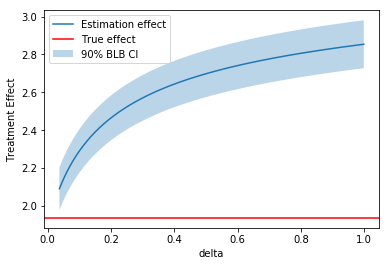

In [23]:
from matplotlib import pyplot as plt

fig = plt.figure()
plt.plot(delta_seq, means_train, label='Estimation effect')
plt.axhline(y=true_effect_train, color='r', linestyle='-', label = "True effect")
plt.fill_between(np.array(delta_seq).reshape(-1), lowers_train, uppers_train, label="90% BLB CI", alpha=0.3)
plt.ylabel("Treatment Effect")
plt.xlabel("delta")
# plt.title("The changes of effects depending on delta")
plt.legend()
plt.show()
fig.savefig(ecf.FIGURE_PATH + '/a_b_testing_train.png')


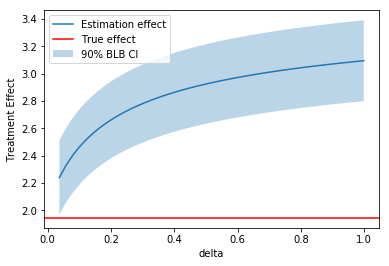

In [24]:
fig = plt.figure()
plt.plot(delta_seq, means_test, label='Estimation effect')
plt.axhline(y=true_effect_test, color='r', linestyle='-', label = "True effect")
plt.fill_between(np.array(delta_seq).reshape(-1), lowers_test, uppers_test, label="90% BLB CI", alpha=0.3)
plt.ylabel("Treatment Effect")
plt.xlabel("delta")
# plt.title("The changes of effects depending on delta")
plt.legend()
plt.show()
fig.savefig(ecf.FIGURE_PATH + '/a_b_testing_test.png')


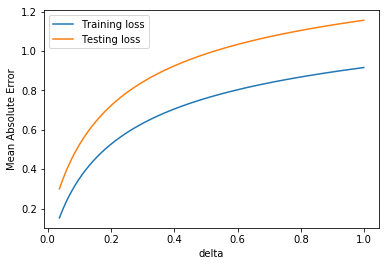

In [25]:
fig = plt.figure()
plt.plot(delta_seq, losses, label='Training loss')
plt.plot(delta_seq, losses_test, label='Testing loss')

plt.ylabel("Mean Absolute Error")
plt.xlabel("delta")
# plt.title("The changes of effects depending on delta")
plt.legend()
plt.show()
fig.savefig(ecf.FIGURE_PATH + '/mae.png')


## Compare with other methods

### BART

In [47]:
def causal_bart(data, bart_model):
    data_pos = data.copy()
    data_pos[treatment] = 1
    data['treated_cf_outcome'] = bart_model.predict(data_pos[features])

    ## Compute counterfactual outcome with treatment
    data_neg = data.copy()
    data_neg[treatment] = 0
    data['control_cf_outcome'] = bart_model.predict(data_neg[features])
    
    return np.mean(data['treated_cf_outcome'] - data['control_cf_outcome'])

In [48]:
train, test = train_test_split(ab_data, test_size=0.2, random_state = 1)
train = train.reset_index(drop = True)
test = test.reset_index(drop = True)


In [49]:
bart_model = SklearnModel(n_trees = 1) # Use default parameters
bart_model.fit(train[features].values, train[outcome].values)

effects_train = causal_bart(train, bart_model)
effects_test = causal_bart(test, bart_model)

mae_bart_train = utils.abs_ate(true_effect_train, effects_train)
mae_bart_test = utils.abs_ate(true_effect_test, effects_test)



In [50]:
result_dic['bart_train'] = mae_bart_train
result_dic['bart_test'] = mae_bart_test

### TMLE

In [51]:
train, test = train_test_split(ab_data, test_size=0.2, random_state = 1)
train = train.reset_index(drop = True)
test = test.reset_index(drop = True)


expose_m = ' + '.join(cov)
outcome_m = ' + '.join(features)

model_t = LogisticRegression(penalty='l2', random_state=201)
model_y = GradientBoostingRegressor(random_state=0, n_estimators = 5000)

tml = TMLE(train, exposure=treatment, outcome=outcome)
tml.exposure_model(expose_m, bound=[0.01, 0.99], print_results=False, custom_model=model_t)
tml.outcome_model(outcome_m, print_results=False, custom_model = model_y)
tml.fit()

mae_train = utils.abs_ate(true_effect_train, tml.average_treatment_effect)

tml = TMLE(test, exposure=treatment, outcome=outcome)
tml.exposure_model(expose_m, bound=[0.01, 0.99], print_results=False, custom_model=model_t)
tml.outcome_model(outcome_m, print_results=False)
tml.fit()

mae_test = utils.abs_ate(true_effect_test, tml.average_treatment_effect)


result_dic['tmle_train'] = mae_train
result_dic['tmle_test'] = mae_test


/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/s

### KNN and Linear Regression

In [52]:
train, test = train_test_split(ab_data, test_size=0.2, random_state = 1)
train = train.reset_index(drop = True)
test = test.reset_index(drop = True)


model = CausalModel(data=train,
                    treatment=treatment,
                    outcome=outcome,
                    common_causes=cov, proceed_when_unidentifiable=True)
train[treatment] = [bool(x) for x in train[treatment]]
identified_estimand = model.identify_effect()

estimate_we = model.estimate_effect(
        identified_estimand, method_name="backdoor.propensity_score_matching")

estimate_linear = model.estimate_effect(
        identified_estimand, method_name="backdoor.linear_regression")


model = CausalModel(data=test,
                    treatment=treatment,
                    outcome=outcome,
                    common_causes=cov, proceed_when_unidentifiable=True)
test[treatment] = [bool(x) for x in test[treatment]]
identified_estimand = model.identify_effect()

estimate_we_test = model.estimate_effect(
    identified_estimand, method_name="backdoor.propensity_score_matching")

estimate_linear_test = model.estimate_effect(
        identified_estimand, method_name="backdoor.linear_regression")

knn_train = utils.abs_ate(true_effect_train, estimate_we.value)
knn_test = utils.abs_ate(true_effect_test, estimate_we_test.value)
lr_train = utils.abs_ate(true_effect_train, estimate_linear.value)
lr_test = utils.abs_ate(true_effect_test, estimate_linear_test.value)


result_dic['knn_train'] = knn_train
result_dic['knn_test'] = knn_test

result_dic['lr_train'] = lr_train
result_dic['lr_test'] = lr_test

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['became_member'] on outcome ['days_visited_post']
INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['locale_en_US', 'easier_signup', 'days_visited_fs_pre', 'days_visited_exp_pre', 'days_visited_free_pre', 'days_visited_rs_pre', 'U', 'revenue_pre', 'os_type_osx', 'days_visited_hs_pre', 'days_visited_vrs_pre', 'os_type_windows']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: days_visited_post~became_member+locale_en_US+easier_signup+days_visited_f

                            OLS Regression Results                            
Dep. Variable:      days_visited_post   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     5580.
Date:                Sat, 18 Jul 2020   Prob (F-statistic):               0.00
Time:                        11:16:58   Log-Likelihood:            -2.5403e+05
No. Observations:               80000   AIC:                         5.081e+05
Df Residuals:                   79987   BIC:                         5.082e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9401      0.096     20.244      0.0

/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: days_visited_post~became_member+locale_en_US+easier_signup+days_visited_fs_pre+days_visited_exp_pre+days_visited_free_pre+days_visited_rs_pre+revenue_pre+os_type_osx+days_visited_hs_pre+days_visited_vrs_pre+os_type_windows


                            OLS Regression Results                            
Dep. Variable:      days_visited_post   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     1396.
Date:                Sat, 18 Jul 2020   Prob (F-statistic):               0.00
Time:                        11:17:10   Log-Likelihood:                -63651.
No. Observations:               20000   AIC:                         1.273e+05
Df Residuals:                   19987   BIC:                         1.274e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7701      0.193      9.165      0.0

In [96]:
lr_train, lr_test, knn_train, knn_test

### Causal Forest

In [53]:
train, test = train_test_split(ab_data, test_size=0.2, random_state = 1)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

cf = CausalForest(
        num_trees=1,
        split_ratio=0.5,
        min_leaf=5,
        max_depth=20,
        use_transformed_outcomes=True,
        num_workers=4,
        seed_counter=1,
    )

train['term_t'] = train[treatment].apply(lambda x: bool(x))
test['term_t'] = test[treatment].apply(lambda x: bool(x))
    
    
cf = cf.fit(train[features].values, train['term_t'].values, train[outcome].values)

cf_train = np.mean(cf.predict(train[features].values))
cf_test = np.mean(cf.predict(test[features].values))

mae_train = utils.abs_ate(true_effect_train, cf_train)
mae_test = utils.abs_ate(true_effect_test, cf_test)


In [54]:
result_dic['causal_forest_train'] = mae_train
result_dic['causal_forest_test'] = mae_test

### Ortho

In [55]:
train, test = train_test_split(ab_data, test_size=0.2, random_state = 1)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [56]:
true_effect_test = np.mean(TE_fn(test[cov]))
true_effect_train = np.mean(TE_fn(train[cov]))

In [57]:
train[treatment].value_counts()

0    51873
1    28127
Name: became_member, dtype: int64

In [89]:
## Linear

print("Doubly Linear Learner")
est = LinearDRLearner(model_propensity=GradientBoostingClassifier(),
                      model_regression=GradientBoostingRegressor())
est.fit(Y = train[outcome].values, T = train[treatment].values, X = train[features].values, inference='statsmodels')
ate_dr_train = np.mean(est.effect(train[features].values))
ate_dr_test = np.mean(est.effect(test[features].values))

## Forest
print("Doubly Forest Learner")
est = ForestDRLearner(model_propensity=GradientBoostingClassifier(),
                  model_regression=GradientBoostingRegressor(), n_estimators=10)
est.fit(Y = train[outcome].values, T = train[treatment].values, X = train[features].values, inference='blb')
ate_fdr_train = np.mean(est.effect(train[features].values))
ate_fdr_test = np.mean(est.effect(test[features].values))






Doubly Linear Learner
Doubly Forest Learner


In [90]:
print("Orthogonal Forest")
est = DiscreteTreatmentOrthoForest(n_trees=50,
                                   model_Y = WeightedLasso(alpha=0.5),
                                  min_leaf_size=50)

est.fit(Y = train[outcome].values, T = train[treatment].values, X = train[features].values, inference='blb')

# ate_ortho_train = np.mean(est.effect(train[features].values))
# ate_ortho_test = np.mean(est.effect(test[features].values))

Orthogonal Forest


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  50 | elapsed:   15.0s remaining:   11.8s
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed:   16.5s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   17.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  50 | elapsed:    4.3s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed:    6.1s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    6.8s finished


In [80]:
ate_ortho_train = np.mean(est.effect(train[features].values))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge"

/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-pack

ValueError: The original error: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1 This might be caused by too few sample in the tree leafs. Try increasing the min_leaf_size.

/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-pack

In [93]:
# ortho_train = utils.abs_ate(true_effect_train, ate_ortho_train)
dr_train = utils.abs_ate(true_effect_train, ate_dr_train)
fdr_train = utils.abs_ate(true_effect_train, ate_fdr_train)

# ortho_test = utils.abs_ate(true_effect_test, ate_ortho_test)
dr_test = utils.abs_ate(true_effect_test, ate_dr_test)
fdr_test = utils.abs_ate(true_effect_test, ate_fdr_test)

In [94]:
# result_dic['ortho_train'] = ortho_train
# result_dic['ortho_test'] = ortho_test

result_dic['linear_dr_train'] = dr_train
result_dic['linear_dr_test'] = dr_test

result_dic['forest_dr_train'] = fdr_train
result_dic['forest_dr_test'] = fdr_test


In [95]:
dr_train, dr_test, fdr_train, fdr_test

## Conclusion

In [61]:
for k,v in result_dic.items():
    print(k,v)

ortho_train 0
ortho_test 0
linear_dr_train 0.26501444607365965
linear_dr_test 0.27232296317980964
forest_dr_train 0.13697876459239566
forest_dr_test 0.14704058320432378
incremental_train 0.15401796943664547
incremental_test 0.2941702352142337
causal_forest_train 2.5369207107433445
causal_forest_test 2.4899266545036625
tmle_train 1.229785953268098
tmle_test 1.3752147557064587
knn_train 1.925233571428572
knn_test 2.392006666666667
ps_train 0
ps_test 0
lr_train 2.585516354499278
lr_test 2.664209536418954
bart_train 1.530356902408526
bart_test 1.5312256391475525


In [97]:
df_result = pd.DataFrame()
df_result['Method'] = ''
df_result['Training'] = ''
df_result['Testing'] = ''

results = []
results.append(['OLS', result_dic['lr_train'], result_dic['lr_test']])
results.append(['K-NN', result_dic['knn_train'], result_dic['knn_test']])
results.append(['BART', result_dic['bart_train'], result_dic['bart_test']])
results.append(['Causal Forest', result_dic['causal_forest_train'], result_dic['causal_forest_test']])
results.append(['Orthogonal Random Forest', result_dic['linear_dr_train'], result_dic['linear_dr_train']])
results.append(['ForestDRLearnet', result_dic['forest_dr_train'], result_dic['forest_dr_test']])
results.append(['LinearDRLearner', result_dic['linear_dr_train'], result_dic['linear_dr_test']])
results.append(['TMLE', result_dic['tmle_train'], result_dic['tmle_test']])
results.append(['Incremental Propensity Score', result_dic['incremental_train'], result_dic['incremental_test']])


In [98]:
count = 0
for i in results:
    df_result.loc[count,'Method'] = i[0]
    df_result.loc[count,'Training'] = round(i[1],4)
    df_result.loc[count,'Testing'] = round(i[2],4)
    count +=1


In [99]:
print (df_result.to_latex())

\begin{tabular}{llll}
\toprule
{} &                        Method & Training & Testing \\
\midrule
0 &                           OLS &   2.5855 &  2.6642 \\
1 &                          K-NN &   1.9252 &   2.392 \\
2 &                          BART &   1.5304 &  1.5312 \\
3 &                 Causal Forest &   2.5369 &  2.4899 \\
4 &      Orthogonal Random Forest &   0.2155 &  0.2155 \\
5 &               ForestDRLearnet &   0.2231 &  0.2352 \\
6 &               LinearDRLearner &   0.2155 &  0.2244 \\
7 &                          TMLE &   1.2298 &  1.3752 \\
8 &  Incremental Propensity Score &    0.154 &  0.2942 \\
\bottomrule
\end{tabular}

